In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
#Read the input data from disk
input_data = pd.read_csv("../Project1/data/iris.csv",header=None)

In [7]:
#Separate target columns. They have one hot vector representation of classes
target = input_data[input_data.columns[4:7]]

In [8]:
#Separate the feature columns and normalize them to range (0,1)
input_data = input_data[input_data.columns[0:4]]
input_data = (input_data - input_data.min())/(input_data.max()-input_data.min())
input_data.head().as_matrix()

array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
       [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
       [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
       [ 0.19444444,  0.66666667,  0.06779661,  0.04166667]])

In [9]:
#Separate into test and train sets
x_train,x_test,y_train,y_test = train_test_split(input_data,target,test_size = 0.2,random_state=123)

In [10]:
x_train.shape

(120, 4)

In [18]:
# %load SOMLayer.py
"""
Created on Sun Nov  5 06:40:19 2017

@author: Shreshtha Kulkarni
"""
    
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

#Defines a particular node of the SOM.
#members: codebook_vec or weights, position assuming rectangular topography
#         input_vec_len: dimensions/features in input_data
#         lattice_type: shape of neighborhood area: rectangle/hexagon
class Node:
     #initialize node   
    def __init__(self,pos_x,pos_y,input_vec_len,lattice_type):
        self.codebook_vec = np.random.rand(1,input_vec_len)
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.lattice_type = lattice_type
    
             
    #evaluate if the passed node is a neighbor
    def isMyNeighbor(self,node,infl_radius):
        dist = np.linalg.norm(np.array([self.pos_x,self.pos_y]) - np.array([node.pos_x,node.pos_y]))
        if((self.lattice_type == "rect") and (pow(dist,2) < pow(infl_radius,2))):
            return True
        
        if(self.lattice_type == "hex"):
            R = 1.5*np.sqrt(3)*infl_radius*infl_radius
            if(pow(dist,2) <= R):
                return True
        
        return False

#Defines the SOM network. This will take care of training, updating the learning
#parameters and wts/codebook_vecs
class SOMNetwork:
    
    #Initialise the network. Internally initializes each node individually.
    #params: no_neurons = no. of nodes
    #        input_vec_len = features in input data
    #        topo = topology of network: line if 1D, rect if 2D
    #        topo_x, topo_y = length,width of the rectangle
    #        eta_0 = Initial learning rate
    #        eta_decay_method = method to decay eta: lin <linear>, exp, inv (inverse)
    #        dist_method = distance metric to be used. default is euclidean
    #        lattice_type = as used in node distance computation. default:rect
    def __init__(self,no_neurons,input_vec_len,topo,topo_x,topo_y,eta_0,eta_decay_method
                 ,dist_method,neighborhood_fun,lattice_type):
        if lattice_type is None or lattice_type == "":
            lattice_type = "rect"
        
        if(topo == "line"):
            self.neuron_mat = [Node(0,x,input_vec_len,lattice_type) for x in range(no_neurons)]
        elif(topo == "rect"):
            self.neuron_mat = []
            if(topo_x*topo_y != no_neurons):
                raise ValueError("topo_x*topo_y should be equal to no_neurons")
            for x in range(topo_x):
                for y in range(topo_y):
                    self.neuron_mat.append(Node(x,y,input_vec_len,lattice_type))
        else:
            raise ValueError("Unsupported topology type. Valid type: line,rect")
            
        self.no_neurons = no_neurons
        self.topo = topo
        self.tau_1 = 1000 #some constants to decay influence radius
        self.tau_2 = 1000 #constant to decay learning rate
        self.eta = eta_0
        self.eta_0 = eta_0
        
        self.infl_radius_0 = 1 if topo== "line" else np.linalg.norm([topo_x,topo_y])
        self.infl_radius = self.infl_radius_0
        
        if(dist_method  == "" or dist_method == None):
            self.dist_method = "euclidean"
        else:
            self.dist_method = dist_method
        
        if(eta_decay_method in ["exp","lin","inv"]):
            self.eta_decay_method = eta_decay_method
        elif(eta_decay_method == "" or eta_decay_method == None):
            self.eta_decay_method = "exp"
        else:
            raise ValueError("Invalid value %s for eta_decay_method.Valid are exp, lin or inv" %(eta_decay_method))
            
        if(neighborhood_fun in ["gaussian","bubble"]):
            self.neighborhood_func = neighborhood_fun
        elif(neighborhood_fun == "" or neighborhood_fun == None):
            self.neighborhood_func = "gaussian"
        else:
            raise ValueError("Invalid value %s for neighborhood_fun.Valid are gaussian or bubble" %(neighborhood_fun))
    
    #Get the best matching unit
    def getBMU(self,input_vec):       
        wt_mat = []
        for i in range(self.no_neurons):
            wt_mat.append(self.neuron_mat[i].codebook_vec[0])
        #from IPython.core.debugger import Tracer; Tracer()()
        res = pairwise_distances_argmin_min(np.array(input_vec).reshape(1,-1),wt_mat,metric = self.dist_method)
            
        return (self.neuron_mat[res[0][0]],res[1][0])
    
    #Decay learning rate
    def setDecayedEta(self,epoch):
        if(self.eta_decay_method == "exp"):
            self.eta = self.eta_0 * np.exp(-epoch/self.tau_2) #Exponential decay
        elif(self.eta_decay_method == "lin"):
            self.eta = self.eta_0 *(1- epoch/self.tau_2) #linear decay
        else:
            self.eta = self.eta_0/(epoch+1) #inverse decay
    
    #Decay influence radius
    def setDecayedInfluenceRadius(self,epoch):
        self.infl_radius = self.infl_radius_0 * np.exp(-epoch/self.tau_1)
    
    #Calculate influence value as per a guassian distribution function
    def calculateInfluenceValue(self,neighbor_node,bmu_node):
        #calculate the positional distance in the topographic map of SOM.
        #Its not the distance between wt vectors
        dist = np.linalg.norm(np.array([bmu_node.pos_x,bmu_node.pos_y])-
                                  np.array([neighbor_node.pos_x,neighbor_node.pos_y]))
        #dist=1
        return np.exp(-pow(dist,2)/(2*pow(self.infl_radius,2)))
    
    #Update the codebook vectors
    def updateWeights(self,bmu_node,neighbor_node,input_vec):
        #from IPython.core.debugger import Tracer; Tracer()()
        if(self.neighborhood_func == "gaussian"):
            infl_val = self.calculateInfluenceValue(neighbor_node,bmu_node)
            neighbor_node.codebook_vec += self.eta*infl_val*(input_vec - neighbor_node.codebook_vec)
        else:
            neighbor_node.codebook_vec += self.eta*(input_vec - neighbor_node.codebook_vec) #bubble update

    def updateParameters(self,epoch):
        if(self.eta > 0.01):
            self.setDecayedEta(epoch)
        #Do not update influence radius when it is very small.Assuming that
        #neighboorhood has already reduce to single neuron
        if(self.infl_radius > 0.001):
            self.setDecayedInfluenceRadius(epoch)
    
    #Finp the neighbors of BMU.
    def findNeighbors(self,bmu_node):
        bmu_node_ind = self.neuron_mat.index(bmu_node)
        neighbor_coords = []
                
        if(self.topo == "line"):
            if(self.infl_radius < 1):
                return neighbor_coords #return empty neighbors as neighborhood has shrunk to single neuron
                                       #else infl_val becomes too small producing NaNs in wt update.
            if(bmu_node_ind == 0): #if end neuron
                neighbor_coords.append(1) 
            elif(bmu_node_ind == (len(self.neuron_mat)-1)): #if other end neuron
                neighbor_coords.append(len(self.neuron_mat) - 2)
            else:
                neighbor_coords.append(bmu_node_ind - 1)
                neighbor_coords.append(bmu_node_ind + 1)
        elif(self.topo == "rect"):
            for i in range(len(self.neuron_mat)):
                #Do not append bmu_node as infl_value for itself is 1
                if((i!=bmu_node_ind) and (bmu_node.isMyNeighbor(self.neuron_mat[i],self.infl_radius))):
                    neighbor_coords.append(i)
        return neighbor_coords
            
    #Function to train the network
    def train(self,input_data,num_epochs):
        #Set the decay constants to equal to num_epochs
        self.tau_1 = num_epochs/(np.log(self.infl_radius_0)) if self.infl_radius_0 != 1 else num_epochs
        self.tau_2 = num_epochs
        train_history = dict()
        net_output = dict()
        row_ind = 0
        bmu_list=[]
        eta_history =[]
        mse_history=[]
        infl_rad_history =[]
        repeatInputSet = True
    
        
        for k in range(num_epochs):
            #This loop is to ensure all the training instances are used once atleast.
            #Once all are used they are repeated.
            while((repeatInputSet == True) or 
                  ((row_ind in net_output.keys()) and (len(net_output.keys()) < len(input_data)))):
                row_ind = np.random.randint(0,len(input_data))
                repeatInputSet = False
            
            bmu_node,bmu_dist = self.getBMU(input_data[row_ind]) #get best matching unit
            if(bmu_node == None):
                print("row:%d epoch:%d" %(row_ind,k)) #troubleshooting
            
            neighbor_coords = self.findNeighbors(bmu_node) #find neighbors
            #to update the weights of bmu_node. infl_val =1
            bmu_node.codebook_vec += self.eta*(input_data[row_ind] - bmu_node.codebook_vec) 
            
            #update the neighbor wts. 
            for coord in neighbor_coords:
                self.updateWeights(bmu_node,self.neuron_mat[coord],input_data[row_ind])
        
            #decay learning parameters, but record them prior to update for 
            #generating some graphs at the end
            eta_history.append(self.eta)
            infl_rad_history.append(self.infl_radius)
            self.updateParameters(k)
            
            #Return the output of network in form of one hot vector
            op = np.zeros(self.no_neurons)
            op[self.neuron_mat.index(bmu_node)] =1
            net_output[row_ind] = op
                      
            #Calculate and store the distance of input_vec from BMU for calculating mse 
            #once all the training samples are utilised.
            bmu_list.insert(row_ind,bmu_dist)
            if(len(bmu_list) == len(input_data)):
                #from IPython.core.debugger import Tracer; Tracer()()
                mse = sum(bmu_list)/len(input_data)
                print("MSE : %0.2f" %(mse))  
                mse_history.append(mse) #for future plots
                bmu_list=[]
                repeatInputSet = True
        #from IPython.core.debugger import Tracer; Tracer()()
        train_history['eta'] = eta_history
        train_history['mse'] = mse_history
        train_history['irad'] = infl_rad_history
        return(train_history,net_output)
    
    #Map the input data to network nodes and output the one hot vector representation
    #output where BMU =1 and other nodes =0
    def mapInput(self,input_data):
        node_output = [] #This will be the layer output in the form of one hot vector
        
        for i in range(len(input_data)):
            bmu_node,bmu_dist = self.getBMU(input_data[i])
            op = np.zeros(  self.no_neurons)
            op[self.neuron_mat.index(bmu_node)] =1
            node_output.insert(i,op)
        
        return np.array(node_output)
    
    '''def dotProdSim(self,input_vec):
        dp = []
        for i in range(self.no_neurons):
            dp[i] = np.dot(input_vec,self.neuron_mat[i].codebook_vec[0])
        
        return self.neuron_mat[dp.index(max(dp))]'''

#Extra layer to map the SOM output in the target format. For accuarcy calculation.
#it uses and outstar representation of the network.
class GrossbergLayer:
    def __init__(self,in_neurons,out_neurons,eta):
        self.in_neurons = in_neurons
        self.out_neurons = out_neurons
        self.eta = eta
        self.wts = np.random.rand(out_neurons,in_neurons)
        
    def generateResult(self,input_vec):
        y_hat = np.matmul(self.wts,input_vec)
        return y_hat
    
    def train(self,output,target,input_vec):
        self.wts += np.matmul(self.eta*(target - output), input_vec.T)
        

In [12]:
#Function to produce the class clusters at the end of final training.
def classPlot(net,output,target):
    temp = []
    for i in range(len(output)):
        bmu_ind = list(output[i]).index(1)
        temp.append([net.neuron_mat[bmu_ind].pos_x,net.neuron_mat[bmu_ind].pos_y, list(target[i]).index(1)])

    df = pd.DataFrame(temp)
    df.columns = ['x','y','c']

    colors = ['red','blue','green']
    map_cnt = df.groupby(['x','y']).count()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_yticks(ticks=range(np.max([np.shape(net.neuron_mat)])))
    if(net.topo == "line"):
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
    else:
        ax.set_xticks(ticks=range(np.max([np.shape(net.neuron_mat)])))
        
    ax.set_title('Map of class output of each neuron of SOM')
    for name, group in df.groupby(['c']):
        ax.scatter(group['x'], group['y'],c=colors[name],marker=(4,0,0),label=name+1)
    plt.legend(loc=4,title="Class Label")
    plt.show()

In [20]:
#evalaute the network on test data for accuracy
def evaluate_on_test(net,x_test,y_test,eta):
    mo = []
    gb = None
    gb_o = []
    mo = net.mapInput(x_test.as_matrix())
    gb = GrossbergLayer(net.no_neurons,3,eta)
    for i in range(x_test.shape[0]):
        iv = np.matrix(mo[i]).T
        gb_o = gb.generateResult(iv)
        gb.train(gb_o,np.matrix(y_test.as_matrix()[i]).T,iv)
    
    gb_o = gb.generateResult(mo.T)
    mse = np.sum(pow((y_test.as_matrix().T - gb_o).T,2))/len(y_test)
    acc = (np.abs(gb_o.T-y_test.as_matrix()).max(axis =1) < 0.05).sum()/len(x_test)
    print("QE = %0.2f    Accuracy = %0.2f" %(mse,acc))
    return (mo,gb_o,acc)

In [452]:
#Best network
som =  SOMNetwork(10,4,"line",0,0,0.1,"lin","euclidean","bubble","rect")
t_his,output = som.train(x_train.as_matrix(),6000)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.22
MSE : 0.02
MSE : 0.01
MSE : 0.01
MSE : 0.04
MSE : 0.01
MSE : 0.02
MSE : 0.04
MSE : 0.02
MSE : 0.04
MSE : 0.01
MSE : 0.05
MSE : 0.05
MSE : 0.06
MSE : 0.03
MSE : 0.03
MSE : 0.05
MSE : 0.04
MSE : 0.03
MSE : 0.03
MSE : 0.00
MSE : 0.04
MSE : 0.03
MSE : 0.03
MSE : 0.05
MSE : 0.03
MSE : 0.05
MSE : 0.02
MSE : 0.01
MSE : 0.02
MSE : 0.03
MSE : 0.09
MSE : 0.07
MSE : 0.12
MSE : 0.06
MSE : 0.09
MSE : 0.04
MSE : 0.10
MSE : 0.07
MSE : 0.04
MSE : 0.01
MSE : 0.00
MSE : 0.10
MSE : 0.12
MSE : 0.00
MSE : 0.17
MSE : 0.14
MSE : 0.18
MSE : 0.05
MSE : 0.12


In [453]:
som_out,gb_out = evaluate_on_test(som,x_test,y_test,0.95)

QE = 0.07    Accuracy = 0.97


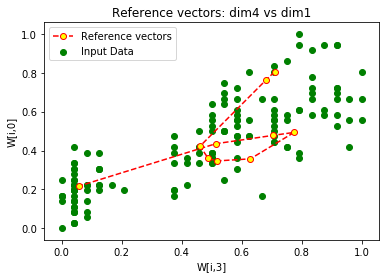

In [537]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = [som.neuron_mat[i].codebook_vec[0][3] for i in range(som.no_neurons)]
y = [som.neuron_mat[i].codebook_vec[0][0] for i in range(som.no_neurons)]
ax1.plot(x,y,color="red",linestyle='dashed',marker='o',markerfacecolor='yellow',label="Reference vectors")
ax1.scatter(input_data[3],input_data[0],color="green",label="Input Data")
ax1.set_title('Reference vectors: dim4 vs dim1')
ax1.set_xlabel('W[i,3]')
ax1.set_ylabel('W[i,0]')
plt.legend()
plt.show()

In [456]:
som_out,gb_out = evaluate_on_test(som,input_data,target,0.95)

QE = 0.17    Accuracy = 0.91


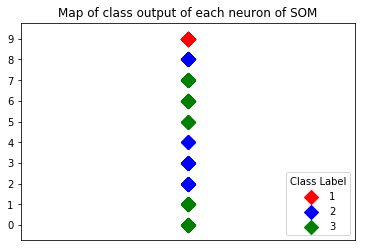

In [531]:
temp = []
for i in range(len(som_out)):
    bmu_ind = list(som_out[i]).index(1)
    temp.append([som.neuron_mat[bmu_ind].pos_x,som.neuron_mat[bmu_ind].pos_y, list(np.round(gb_out.T)[i]).index(1)])

df = pd.DataFrame(temp)
df.columns = ['x','y','c']
colors = ['red','blue','green']
map_cnt = df.groupby(['x','y']).count()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yticks(ticks=range(np.max([np.shape(som.neuron_mat)])))
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
ax.set_title('Map of class output of each neuron of SOM')
for name, group in df.groupby(['c']):
    ax.scatter(group['x'], group['y'],c=colors[name],s=200,marker=(4,0,0),label=name+1)
plt.legend(loc=4,title="Class Label")
plt.show()

In [325]:
#dist = euclidean, eta_decay = lin, h = bubble
som =  SOMNetwork(9,4,"line",0,0,3,"lin","euclidean","bubble","rect")
t_his,output = som.train(x_train.as_matrix(),5000)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 444483.07
MSE : 2147256603902.90
MSE : 4116472721362140160.00
MSE : 3020733195164449129889792.00
MSE : 815989917228797381547258806272.00
MSE : 77797680844772842785234808108744704.00
MSE : 2502811007764960160518337773795775873024.00
MSE : 25880406377534335377175171967810316011569152.00
MSE : 81677146010958474991533144260190357279742099456.00
MSE : 74506627292361524559233176836756477348519623000064.00
MSE : 18583282826527793859405825187970588254565032947351552.00
MSE : 1202217732400262559142681316183709244508291126618226688.00
MSE : 19284849873330465311133045603339063630274208022430482432.00
MSE : 73990522649020708536482887295787858589177333421573144576.00
MSE : 29853949865710887986744468077884296341579460880959012864.00
MSE : 41623052815937499934331161402567549471493643390943232.00
MSE : 9430754292047106793206162052620304140990414848.00
MSE : 99575954823054876164628318447992832.00
MSE : 16956325909769793536.00
MSE : 0.02
MSE : 0.02
MSE : 0.00
MSE : 0.02
MSE : 0.02
MSE : 0.00
MSE :

In [332]:
som_out,gb_out = evaluate_on_test(som,x_test,y_test,0.95)

QE = 0.05    Accuracy = 0.97


In [327]:
np.mean(t_his['mse'])

3.0339468549723379e+54

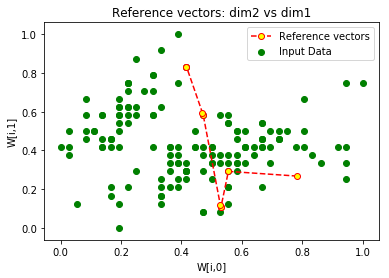

In [328]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = [som.neuron_mat[i].codebook_vec[0][0] for i in range(som.no_neurons)]
y = [som.neuron_mat[i].codebook_vec[0][1] for i in range(som.no_neurons)]
ax1.plot(x,y,color="red",linestyle='dashed',marker='o',markerfacecolor='yellow',label="Reference vectors")
ax1.scatter(input_data[0],input_data[1],color="green",label="Input Data")
ax1.set_title('Reference vectors: dim2 vs dim1')
ax1.set_xlabel('W[i,0]')
ax1.set_ylabel('W[i,1]')
plt.legend()
plt.show()

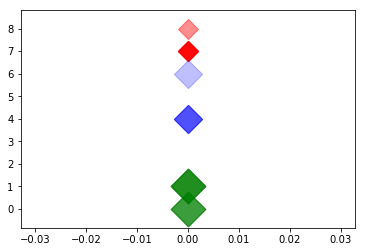

In [342]:
classPlot(som,som_out,np.round(gb_out.T))

In [359]:
#dist = euclidean, eta_decay = exp, h = bubble
som =  SOMNetwork(9,4,"line",0,0,1,"exp","euclidean","bubble","rect")
t_his,output = som.train(x_train.as_matrix(),5000)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.25
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01


In [360]:
som_out,gb_out = evaluate_on_test(som,x_test,y_test,0.95)

QE = 0.12    Accuracy = 0.80


In [361]:
np.mean(t_his['mse'])

0.011926160740825578

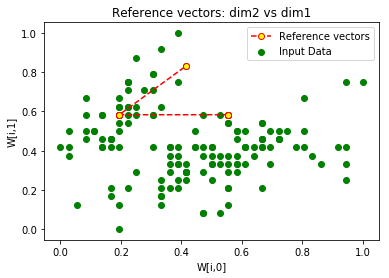

In [362]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = [som.neuron_mat[i].codebook_vec[0][0] for i in range(som.no_neurons)]
y = [som.neuron_mat[i].codebook_vec[0][1] for i in range(som.no_neurons)]
ax1.plot(x,y,color="red",linestyle='dashed',marker='o',markerfacecolor='yellow',label="Reference vectors")
ax1.scatter(input_data[0],input_data[1],color="green",label="Input Data")
ax1.set_title('Reference vectors: dim2 vs dim1')
ax1.set_xlabel('W[i,0]')
ax1.set_ylabel('W[i,1]')
plt.legend()
plt.show()

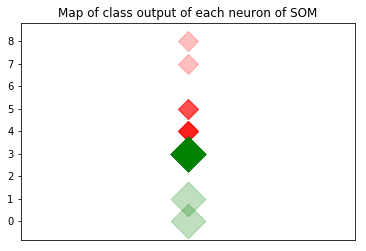

In [363]:
classPlot(som,som_out,np.round(gb_out.T))

In [364]:
#dist = euclidean, eta_decay = exp, h = gaussian
som =  SOMNetwork(9,4,"line",0,0,1,"exp","euclidean","gaussian","rect")
t_his,output = som.train(x_train.as_matrix(),5000)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.21
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00


In [365]:
som_out,gb_out = evaluate_on_test(som,x_test,y_test,0.95)

QE = 0.11    Accuracy = 0.80


In [366]:
np.mean(t_his['mse'])

0.0085505169438535936

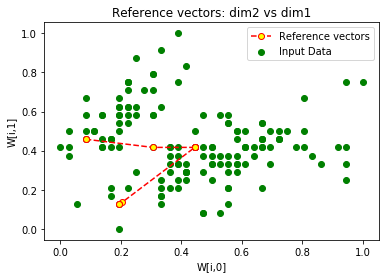

In [367]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = [som.neuron_mat[i].codebook_vec[0][0] for i in range(som.no_neurons)]
y = [som.neuron_mat[i].codebook_vec[0][1] for i in range(som.no_neurons)]
ax1.plot(x,y,color="red",linestyle='dashed',marker='o',markerfacecolor='yellow',label="Reference vectors")
ax1.scatter(input_data[0],input_data[1],color="green",label="Input Data")
ax1.set_title('Reference vectors: dim2 vs dim1')
ax1.set_xlabel('W[i,0]')
ax1.set_ylabel('W[i,1]')
plt.legend()
plt.show()

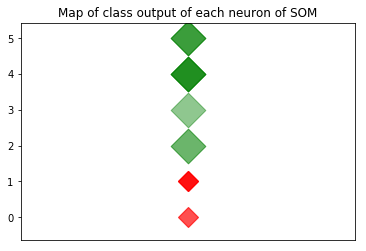

In [368]:
classPlot(som,som_out,np.round(gb_out.T))

In [412]:
def runNetwork(n_nodes,input_len,topo,x,y,eta,eta_decay,dist_metric,
               neighborhood_fun,lattice,n_epochs,input_data,test_data,test_target):
    som =  SOMNetwork(n_nodes,input_len,topo,x,y,eta,eta_decay,dist_metric,neighborhood_fun,lattice)
    t_his,output = som.train(input_data,n_epochs)
    som_out,gb_out = evaluate_on_test(som,test_data,test_target,0.95)
    print("Average MSE training: %0.2f" %(np.mean(t_his['mse'])))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    x = [som.neuron_mat[i].codebook_vec[0][0] for i in range(som.no_neurons)]
    y = [som.neuron_mat[i].codebook_vec[0][1] for i in range(som.no_neurons)]
    ax1.plot(x,y,color="red",linestyle='dashed',marker='o',markerfacecolor='yellow',label="Reference vectors")
    ax1.scatter(input_data[2],input_data[1],color="green",label="Input Data")
    ax1.set_title('Reference vectors: dim2 vs dim1')
    ax1.set_xlabel('W[i,0]')
    ax1.set_ylabel('W[i,1]')
    plt.legend()
    plt.show()
    return (som,som_out,gb_out)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.22
MSE : 0.07
MSE : 0.73
MSE : 0.10
MSE : 0.05
MSE : 0.60
MSE : 0.35
MSE : 0.38
MSE : 0.45
MSE : 0.42
MSE : 0.43
MSE : 0.43
MSE : 0.82
MSE : 0.72
MSE : 0.42
MSE : 0.38
MSE : 0.73
MSE : 0.73
MSE : 0.43
MSE : 0.32
MSE : 0.08
MSE : 0.00
MSE : 0.08
MSE : 0.09
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
QE = 0.12    Accuracy = 0.80
Average MSE training: 0.22


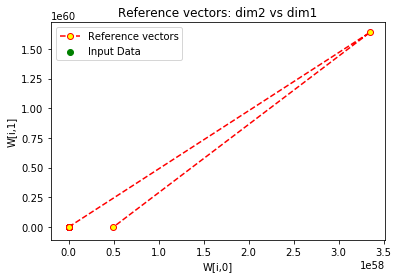

In [380]:
som,som_out,gb_out = runNetwork(9,4,"line",0,0,3,"lin","cosine","bubble","rect",5000,x_train.as_matrix(),x_test,y_test)

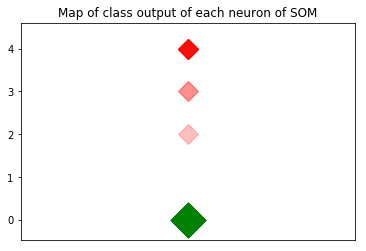

In [381]:
classPlot(som,som_out,np.round(gb_out.T))

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.10
MSE : 0.34
MSE : 0.03
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
QE = 0.11    Accuracy = 0.80
Average MSE training: 0.01


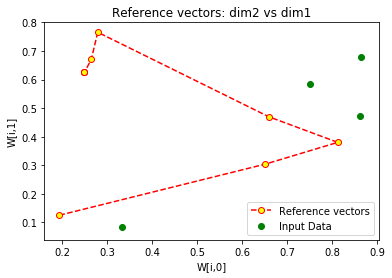

In [382]:
som,som_out,gb_out = runNetwork(9,4,"line",0,0,3,"lin","cosine","gaussian","rect",5000,x_train.as_matrix(),x_test,y_test)

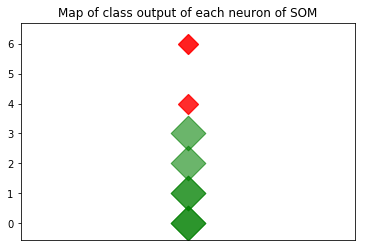

In [383]:
classPlot(som,som_out,np.round(gb_out.T))

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.15
MSE : 0.06
MSE : 0.23
MSE : 0.02
MSE : 0.01
MSE : 0.03
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
QE = 0.12    Accuracy = 0.77
Average MSE training: 0.01


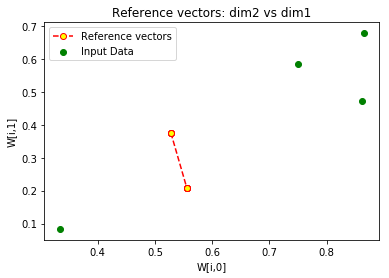

In [384]:
som,som_out,gb_out = runNetwork(9,4,"line",0,0,3,"exp","cosine","gaussian","rect",5000,x_train.as_matrix(),x_test,y_test)

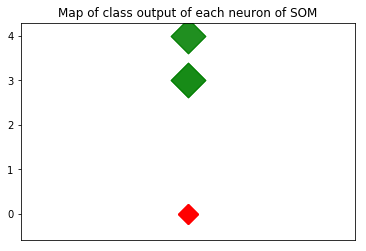

In [385]:
classPlot(som,som_out,np.round(gb_out.T))

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.34
MSE : 0.45
MSE : 0.44
MSE : 0.57
MSE : 0.50
MSE : 0.56
MSE : 0.19
MSE : 0.18
MSE : 0.37
MSE : 0.67
MSE : 0.53
MSE : 0.56
MSE : 0.56
MSE : 0.66
MSE : 0.49
MSE : 0.54
MSE : 0.50
MSE : 0.56
MSE : 0.43
MSE : 0.40
MSE : 0.55
MSE : 0.67
MSE : 0.52
MSE : 0.72
MSE : 0.51
MSE : 0.12
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
QE = 0.19    Accuracy = 0.43
Average MSE training: 0.31


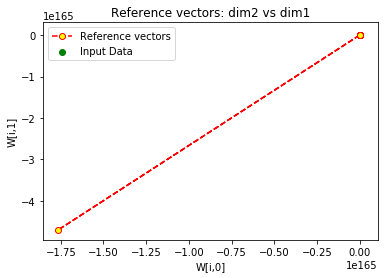

In [386]:
som,som_out,gb_out = runNetwork(9,4,"line",0,0,3,"exp","cosine","bubble","rect",5000,x_train.as_matrix(),x_test,y_test)

MSE : 0.59
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.02
MSE : 0.01
MSE : 0.01
MSE : 0.03
MSE : 0.02
MSE : 0.01
MSE : 0.04
MSE : 0.02
MSE : 0.00
MSE : 0.08
MSE : 0.12
QE = 0.06    Accuracy = 0.93
Average MSE training: 0.03


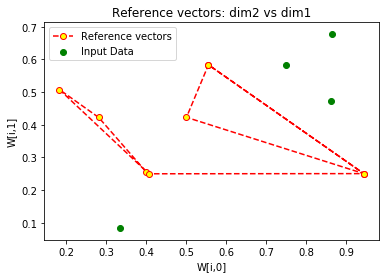

In [393]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,1,"lin","euclidean","bubble","rect",5000,x_train.as_matrix(),x_test,y_test)

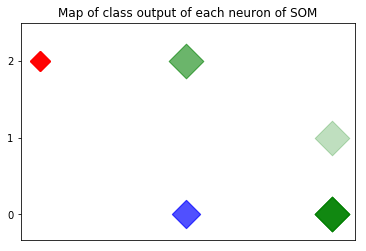

In [395]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.50
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.02
MSE : 0.02
MSE : 0.02
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.02
MSE : 0.03
MSE : 0.03
MSE : 0.02
MSE : 0.01
MSE : 0.02
MSE : 0.00
MSE : 0.03
MSE : 0.01
MSE : 0.01
MSE : 0.04
MSE : 0.02
MSE : 0.01
MSE : 0.01
MSE : 0.01
MSE : 0.03
MSE : 0.01
MSE : 0.02
MSE : 0.07
MSE : 0.04
MSE : 0.03
MSE : 0.05
QE = 0.04    Accuracy = 0.97
Average MSE training: 0.03


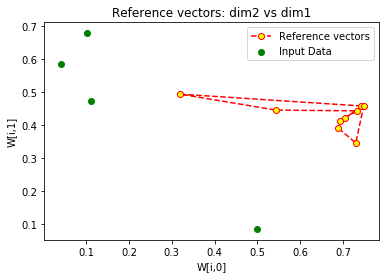

In [399]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,0.7,"lin","euclidean","gaussian","rect",5000,x_train.as_matrix(),x_test,y_test)

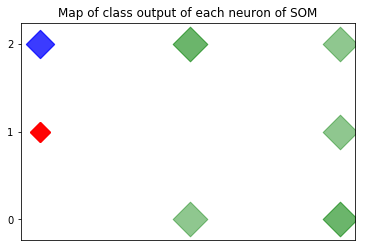

In [402]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.44
MSE : 0.01
MSE : 0.07
MSE : 0.01
MSE : 0.01
MSE : 0.03
MSE : 0.09
MSE : 0.02
MSE : 0.08
MSE : 0.10
MSE : 0.03
MSE : 0.03
MSE : 0.12
MSE : 0.03
MSE : 0.06
MSE : 0.03
MSE : 0.04
MSE : 0.04
MSE : 0.03
MSE : 0.09
MSE : 0.03
MSE : 0.05
MSE : 0.07
MSE : 0.03
MSE : 0.04
MSE : 0.04
MSE : 0.04
MSE : 0.02
MSE : 0.07
MSE : 0.08
MSE : 0.09
MSE : 0.02
MSE : 0.02
MSE : 0.04
MSE : 0.18
MSE : 0.08
MSE : 0.10
MSE : 0.05
MSE : 0.09
MSE : 0.12
MSE : 0.09
QE = 0.09    Accuracy = 0.87
Average MSE training: 0.07


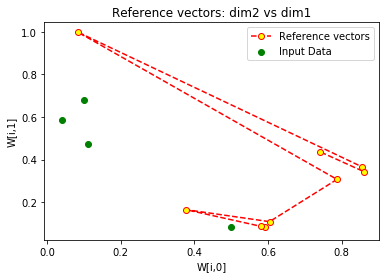

In [405]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,0.1,"exp","euclidean","gaussian","rect",5000,x_train.as_matrix(),x_test,y_test)

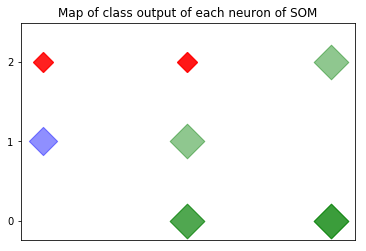

In [406]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.47
MSE : 0.03
MSE : 0.04
MSE : 0.02
MSE : 0.08
MSE : 0.04
MSE : 0.03
MSE : 0.10
MSE : 0.07
MSE : 0.08
MSE : 0.03
MSE : 0.10
MSE : 0.04
MSE : 0.08
MSE : 0.01
MSE : 0.03
MSE : 0.08
MSE : 0.02
MSE : 0.04
MSE : 0.07
MSE : 0.07
MSE : 0.09
MSE : 0.05
MSE : 0.05
MSE : 0.04
MSE : 0.04
MSE : 0.05
MSE : 0.01
MSE : 0.00
MSE : 0.14
MSE : 0.08
MSE : 0.07
MSE : 0.05
MSE : 0.01
MSE : 0.03
MSE : 0.05
MSE : 0.02
MSE : 0.07
MSE : 0.05
MSE : 0.02
MSE : 0.08
QE = 0.07    Accuracy = 0.93
Average MSE training: 0.06


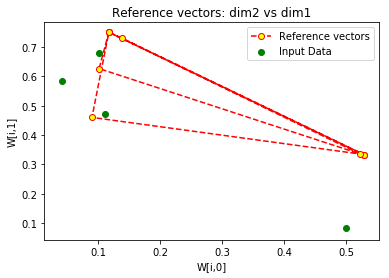

In [407]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,0.1,"exp","euclidean","bubble","rect",5000,x_train.as_matrix(),x_test,y_test)

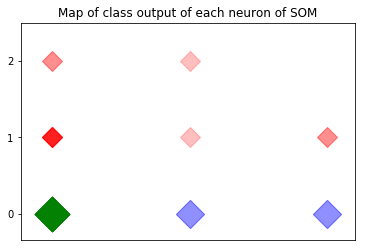

In [408]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.17
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
QE = 0.12    Accuracy = 0.80
Average MSE training: 0.01


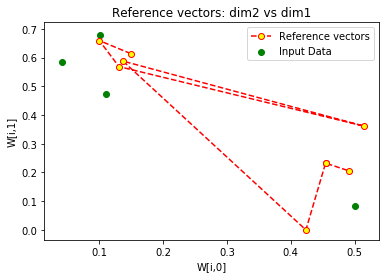

In [413]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,0.7,"lin","cosine","bubble","rect",5000,x_train.as_matrix(),x_test,y_test)

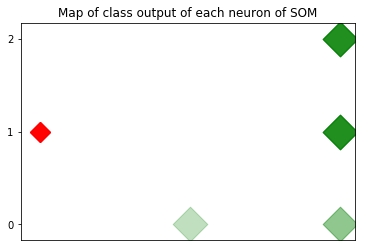

In [414]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.13
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.02
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
QE = 0.11    Accuracy = 0.80
Average MSE training: 0.00


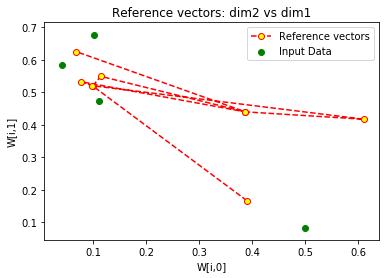

In [416]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,0.7,"lin","cosine","gaussian","rect",5000,x_train.as_matrix(),x_test,y_test)

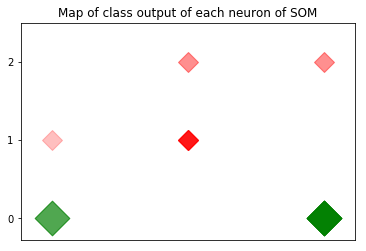

In [417]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.43
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
QE = 0.10    Accuracy = 0.83
Average MSE training: 0.01


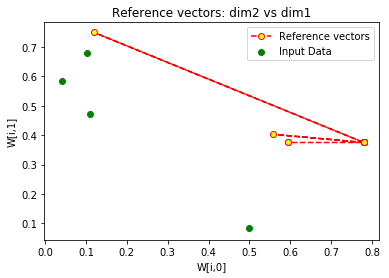

In [419]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,2,"exp","cosine","gaussian","rect",5000,x_train.as_matrix(),x_test,y_test)

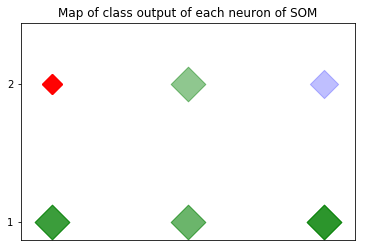

In [420]:
classPlot(som,som_out,np.round(gb_out.T))

MSE : 0.88
MSE : 0.14
MSE : 0.00
MSE : 0.00
MSE : 0.02
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
QE = 0.12    Accuracy = 0.77
Average MSE training: 0.03


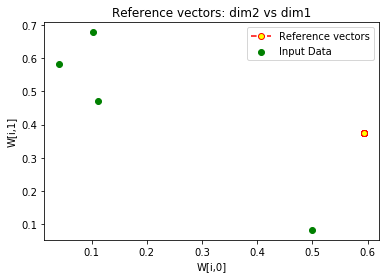

In [421]:
som,som_out,gb_out = runNetwork(9,4,"rect",3,3,2,"exp","cosine","bubble","rect",5000,x_train.as_matrix(),x_test,y_test)

C:\Users\swagat\.conda\envs\shre_root\lib\site-packages\ipykernel\__main__.py:173: RuntimeWarning:

divide by zero encountered in double_scalars



MSE : 0.28
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.01
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
MSE : 0.00
QE = 0.13    Accuracy = 0.73
Average MSE training: 0.01


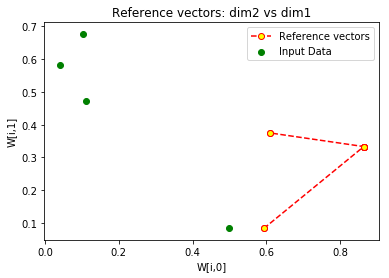

In [422]:
som,som_out,gb_out = runNetwork(9,4,"line",3,3,2,"exp","euclidean","gaussian","hex",5000,x_train.as_matrix(),x_test,y_test)